This notebook is made to create and test the models we used for our application and to report the final results.

We will use MFCC images with the parameters *hop_length=1024* and *n_mfcc=20*, which will result in images having 20x130 resolution.

In [1]:
%matplotlib inline

from IPython.display import Audio
from IPython.display import Image


import sklearn.preprocessing
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np 
import librosa as lr
import librosa.display
import matplotlib.pyplot as plt
import wave
import soundfile as sf
import math
import visualkeras

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

This notebook is used to make a model for recognizing *instrument_of_interest* entered below (along with the username to your path) by using the validation data provided by the organizers as the training data. To be more precise, we will use validation sets 1 and 3 for training, and validation set 2 to report the result of the model.

In [2]:
username = "user"
directory = "C:/Users/" + username + "/Downloads/IRMAS_Training_Data/IRMAS_Training_Data"
directory_names = os.listdir(directory)
instrument_of_interest = "gel"
n_coef = 20
redni_broj = directory_names.index(instrument_of_interest)

In [3]:
X_data_vali1 = np.load('1TENZOR_mfcc_NESKALIRANI_HW=1024_VALI1.npy')
y_data_vali1 = np.load(instrument_of_interest + '_1labels_mfcc_NESKALIRANI_HW=1024_VALI1.npy')
X_data_vali3 = np.load('3TENZOR_mfcc_NESKALIRANI_HW=1024_VALI3.npy')
y_data_vali3 = np.load(instrument_of_interest + '_3labels_mfcc_NESKALIRANI_HW=1024_VALI3.npy')

In [4]:
X_data_all = np.append(X_data_vali1, X_data_vali3, axis = 0)
del X_data_vali1
del X_data_vali3

y_data_all = np.append(y_data_vali1, y_data_vali3, axis = 0)
del y_data_vali1
del y_data_vali3

In [5]:
unique, counts = np.unique(y_data_all, return_counts = True)
print(unique)
print(counts)

[0 1]
[7929 3679]


The cell below is used to create new data using some data augmentation techniques that seem appropriate when working with MFCC images. The most notable ones being TimeStretch and PitchShift, which are often used in such cases.\
\
There are many ways to increase training dataset for these tasks. The main reason we are using data augmentation here is to balance out the two classes, but still only use the data from the validation datasets.

In [15]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import audiomentations as A

def augment_mfcc(mfcc):
    # Define the audio augmentations you want to apply
    augment = A.Compose([
        A.AddGaussianNoise(),
        A.TimeStretch(),
        A.PitchShift(),
        # Add more augmentations as needed
    ])

    # Apply the augmentations to each sample in the MFCC data
    augmented_samples = []
    for sample in mfcc:
        augmented_sample = augment(samples=sample, sample_rate=44100)  # Adjust the sample_rate as needed
        augmented_samples.append(augmented_sample)

    # Convert the augmented samples to a numpy array
    augmented = np.array(augmented_samples)

    return augmented

def balance_and_augment_data(mfcc_data, labels):
    # Convert labels to numpy array if needed
    labels = np.array(labels)

    # Calculate class distribution
    class_counts = np.bincount(labels)
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    minority_samples = class_counts[minority_class]
    majority_samples = class_counts[majority_class]

    # Determine the target number of samples for balancing the classes
    target_samples = int(np.mean([minority_samples, majority_samples]))

    # Apply undersampling to the majority class (label 0)
    majority_indices = np.where(labels == majority_class)[0]
    undersampled_majority_indices = np.random.choice(majority_indices, size=target_samples, replace=False)
    undersampled_indices = np.concatenate((undersampled_majority_indices, np.where(labels == minority_class)[0]))

    # Apply oversampling to the minority class (label 1)
    minority_indices = np.where(labels == minority_class)[0]
    oversampled_minority_indices = np.random.choice(minority_indices, size=len(mfcc_data) - target_samples, replace=True)
    oversampled_indices = np.concatenate((undersampled_indices, oversampled_minority_indices))

    # Perform data augmentation for the minority class (label 1) samples
    augmented_data = []
    augmented_labels = []
    for idx in oversampled_indices:
        mfcc = mfcc_data[idx]
        label = labels[idx]
        augmented_data.append(mfcc)
        augmented_labels.append(label)
        if label == minority_class:
            augmented_data.append(augment_mfcc(mfcc))
            augmented_labels.append(label)

    # Convert the augmented data and labels back to numpy arrays
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels


# Example usage
mfcc_data = X_data_all  # Your MFCC data with shape (n_samples, 20, 130)
labels = y_data_all  # Your corresponding labels with shape (n_samples, )

augmented_data, augmented_labels = balance_and_augment_data(mfcc_data, labels)


The ratio of the two classes is shown below.

In [16]:
print(augmented_data.shape)
print(augmented_labels.shape)

unique, counts = np.unique(augmented_labels, return_counts = True)
print(unique)
print(counts)

print(X_data_all.shape)
print(y_data_all.shape)

unique, counts = np.unique(y_data_all, return_counts = True)
print(unique)
print(counts)

(24770, 20, 130)
(24770,)
[0 1]
[ 5804 18966]
(11608, 20, 130)
(11608,)
[0 1]
[7929 3679]


In this case, we will use all of the original data, and add 5000 new samples randomly chosen from the augmented data.

In [17]:
total_number_of_samples = augmented_data.shape[0]
wanted_number_of_samples = 5000

random_indices = np.random.choice(total_number_of_samples, size=wanted_number_of_samples, replace=False)
X_aug_short = augmented_data[random_indices, :, :]
y_aug_short = augmented_labels[random_indices]

In [18]:
X_data = np.append(X_data_all, X_aug_short, axis = 0)
del X_data_all
del augmented_data
y_data = np.append(y_data_all, y_aug_short, axis = 0)
del y_data_all
del augmented_labels

In [19]:
X_data.shape

(16608, 20, 130)

In [20]:
unique, counts = np.unique(y_data, return_counts = True)
print(unique)
print(counts)

[0 1]
[9102 7506]


And finally, we will use ~15000 samples we've made for training due to our computational restrictions. We could try using way more data than this, but the duration of the training would be too long. We will also save the new X_data and y_data so that we don't need to repeat this process again for electric guitar.

In [12]:
# np.save('X_mfcc_'+instrument_of_interest+ '_HW=1024_augmented_validation_set.npy', X_data)
# np.save('y_mfcc_'+instrument_of_interest+'_augmented_validation_set.npy', y_data)

X_data = np.load('X_mfcc_'+instrument_of_interest+ '_HW=1024_augmented_validation_set.npy')
y_data = np.load('y_mfcc_'+instrument_of_interest+'_augmented_validation_set.npy')

In [13]:
# Split the data into training and testing sets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=instrument_of_interest + '_best_model_vali_test_AUGMENTATED_FINAL_test2.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

# Define SGD optimizer with desired parameters
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

del X_data
del y_data

X_train = X_train.reshape((-1, n_coef, 130, 1))
X_test = X_test.reshape((-1, n_coef, 130, 1))
y_train = np.array(y_train)
print(X_train.shape)
y_test = np.array(y_test)
print(y_test.shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, mode='min')

model = Sequential()

model.add(Conv2D(32, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(5, 5), strides = 1, padding='same', activation='relu', input_shape=(n_coef, 130, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same', data_format='channels_last'))
model.add(Dropout(0.25))

model.add(Flatten())  # Add a Flatten layer to flatten the output from the previous layers

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=sgd_optimizer, metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=32, epochs=150, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

(13286, 20, 130, 1)
(3322,)
Epoch 1/150
416/416 [==============================] - 96s 229ms/step - loss: 0.5413 - accuracy: 0.7219 - val_loss: 0.4948 - val_accuracy: 0.7655
Epoch 2/150
416/416 [==============================] - 90s 216ms/step - loss: 0.4762 - accuracy: 0.7719 - val_loss: 0.4322 - val_accuracy: 0.7968
Epoch 3/150
416/416 [==============================] - 87s 210ms/step - loss: 0.4190 - accuracy: 0.8058 - val_loss: 0.3694 - val_accuracy: 0.8338
Epoch 4/150
416/416 [==============================] - 86s 207ms/step - loss: 0.3642 - accuracy: 0.8354 - val_loss: 0.3254 - val_accuracy: 0.8552
Epoch 5/150
416/416 [==============================] - 88s 211ms/step - loss: 0.3227 - accuracy: 0.8566 - val_loss: 0.2869 - val_accuracy: 0.8745
Epoch 6/150
416/416 [==============================] - 90s 217ms/step - loss: 0.2953 - accuracy: 0.8693 - val_loss: 0.3010 - val_accuracy: 0.8703
Epoch 7/150
416/416 [==============================] - 93s 224ms/step - loss: 0.2585 - accuracy:

In [14]:
model2 = keras.models.load_model(instrument_of_interest + '_best_model_vali_test_AUGMENTATED_FINAL_test2.h5')

We will test our model on the third validation dataset (IRMAS_Validation_Data_part2... the one not used for data augmentation and training).\
\
We will test both the last and the best model for comparisson.

The code for making predictions is explained in one of the other notebooks, but our approach is to divide the validation audio files into 3 second intervals, and predict the label for each of the intervals. For each audio file, the majority will win the prediction, and we will proclaim that as the final label. Two instances are shown below, one where the tie goes in favor of label 1, and one where tie goes in favor of label 0.

In [15]:
directory = "C:/Users/" + username + "/Downloads/IRMAS_Validation_Data_part2/IRMAS_Validation_Data_part2"
wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]
validation_files = [os.path.join(directory, f) for f in wav_files]

m=len(validation_files)

final_preds = np.zeros(m)
final_preds2 = np.zeros(m)
final_preds_vece_50 = np.zeros(m)
final_preds2_vece_50 = np.zeros(m)
i=0


for file in validation_files:
    
    print(i)
    
    audio = wave.open(file)
    duration_seconds = audio.getnframes()/audio.getframerate()
    n_intervals = math.ceil(duration_seconds/3)
    pred_labels_temp = np.zeros(n_intervals)
    pred_labels_temp2 = np.zeros(n_intervals)
    
    for j in range(n_intervals-1):
        
        y, sr = librosa.load(file, mono=True, sr=None, offset=j*3.0, duration=3.0)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coef, hop_length=1024)

        mfcc = mfcc.reshape(-1,n_coef,130,1)

        pred_labels_temp[j] = model.predict(mfcc,)
        pred_labels_temp2[j] = model2.predict(mfcc,)
        
    
    y, sr = librosa.load(file, mono=True, sr=None, offset=duration_seconds-3.0, duration=3.0)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_coef, hop_length=1024)
    
    mfcc = mfcc.reshape(-1,n_coef,130,1)
    
    pred_labels_temp[n_intervals-1] = model.predict(mfcc,)
    pred_labels_temp2[n_intervals-1] = model2.predict(mfcc,)
    
    print(pred_labels_temp)
    print(pred_labels_temp2)
    
    jedinice = np.count_nonzero(pred_labels_temp >= 0.25)
    nule = n_intervals - jedinice

    if(jedinice>=nule):
        final_preds[i] = 1
    else:
        final_preds[i] = 0
        
    jedinice2 = np.count_nonzero(pred_labels_temp2 >= 0.25)
    nule2 = n_intervals - jedinice2

    if(jedinice2>=nule2):
        final_preds2[i] = 1
    else:
        final_preds2[i] = 0    

    if(jedinice>nule):
        final_preds_vece_50[i] = 1
    else:
        final_preds_vece_50[i] = 0

    if(jedinice2>nule2):
        final_preds2_vece_50[i] = 1
    else:
        final_preds2_vece_50[i] = 0  
        
    i = i+1 

0
[3.33561907e-08 5.56009839e-12 1.14579152e-10 2.40079345e-11
 3.05186269e-17 1.57554165e-08 4.29163427e-10]
[1.88777922e-05 2.70511809e-08 1.85081160e-06 3.33540129e-07
 9.28313000e-08 3.77878547e-03 1.28865242e-04]
1
[1.80932858e-07 1.61826611e-04 4.76482511e-02 2.12899021e-11
 1.85377807e-11]
[8.61346722e-04 5.35263717e-02 9.91121173e-01 5.91092794e-06
 4.56323960e-06]
2
[1.47759914e-04 2.26736105e-08 4.27070705e-13 5.92051703e-14
 4.31717050e-16 4.67432967e-11 5.60401503e-09]
[6.42159581e-03 9.69320536e-04 3.21235660e-07 1.83385580e-07
 9.85335078e-07 3.16629144e-06 8.71548127e-06]
3
[1.78297022e-09 9.98720288e-01 1.12317324e-01 9.96452451e-01
 7.55289197e-03 4.17204708e-01 8.87049556e-01]
[2.51491173e-07 9.62761223e-01 1.10493779e-01 9.47983503e-01
 3.76571119e-02 7.68382306e-05 3.92007113e-01]
4
[1.08696142e-10 1.71697977e-20 2.95241880e-05 1.11992408e-10
 1.66558808e-10 1.58872779e-13 7.47723231e-17]
[5.13134682e-06 7.07485112e-12 1.85805857e-02 4.42058763e-06
 1.16997957e-03 4

In [16]:
# Determine ground truth labels for validation data
ground_truth_labels = []
for file in validation_files:
    with open(os.path.splitext(file)[0] + '.txt', 'r') as f:
        text = f.read()
    if instrument_of_interest in text:
        ground_truth_labels.append(1)
    else:
        ground_truth_labels.append(0)
ground_truth_labels = np.array(ground_truth_labels)

In [17]:
from sklearn.metrics import accuracy_score

print(accuracy_score(ground_truth_labels, final_preds))
print(accuracy_score(ground_truth_labels, final_preds2))
print(accuracy_score(ground_truth_labels, final_preds_vece_50))
print(accuracy_score(ground_truth_labels, final_preds2_vece_50))

0.7459978655282817
0.768409818569904
0.7556029882604055
0.7812166488794023


In [18]:
unique, counts = np.unique(ground_truth_labels, return_counts = True)
print(unique)
print(counts)

[0 1]
[621 316]


In [19]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(ground_truth_labels, final_preds)
cm2 = confusion_matrix(ground_truth_labels, final_preds2)
cm_vece_50 = confusion_matrix(ground_truth_labels, final_preds_vece_50)
cm2_vece_50 = confusion_matrix(ground_truth_labels, final_preds2_vece_50)

# # Plot the confusion matrix
# plt.imshow(cm, cmap='Blues')

# # Add the values inside the matrix fields
# thresh = cm.max() / 2.0
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

print(cm)
print(cm2)
print(cm_vece_50)
print(cm2_vece_50)

# plt.savefig(instrument_of_interest + 'confusion_matrix.png')

[[488 133]
 [105 211]]
[[492 129]
 [ 88 228]]
[[500 121]
 [108 208]]
[[508 113]
 [ 92 224]]


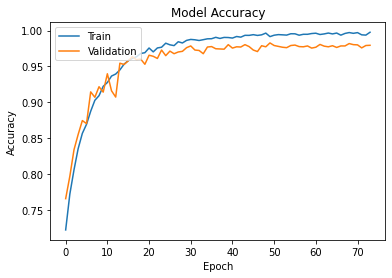

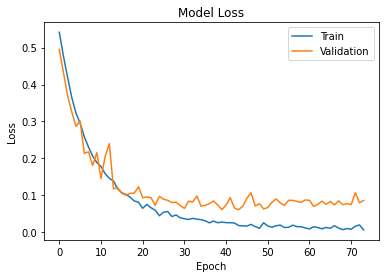

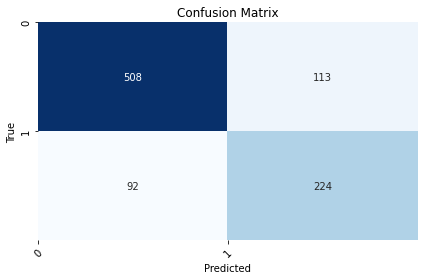

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_model_history(history):
    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the confusion matrix using a heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

    # Set axis labels and title
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

    # Set x and y axis tick labels
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    # Ensure the correct placement of tick labels
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_model_history(history)

plot_confusion_matrix(ground_truth_labels, final_preds2_vece_50, [0, 1])